In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

# 1. Binomial Model


In [2]:
# Basic input parameters for any model used to price options
class OptionContext:
    def __init__(self, strike_price, rate, volatility, maturity, dividend=0):
        self.k = strike_price
        self.r = rate
        self.sigma = volatility
        self.T = maturity
        self.y = dividend
    
# Prices the europaen option given up states, down states, probablity of up state and modeling parameters
def binomial_model(p, u, d, s0, op_ctx, n):
    
    dt = op_ctx.T/n
    
    pu = p
    pd = 1-p
    
    # Initialize the terminal row of the binomial tree with the option payoffs at maturity
    tree = [max(s0 * u ** i * d ** (n - i) - op_ctx.k, 0) for i in range(n + 1)]

    # Iterate backwards through the tree, calculating option values at each level
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            tree[j] = np.exp(-op_ctx.r * dt) * (pu * tree[j + 1] + pd * tree[j])
    
    return tree[0]

# Black scholes price
def black_scholes_call(s0, opt_ctx):
    k = opt_ctx.k
    r = opt_ctx.r
    sigma = opt_ctx.sigma
    t = opt_ctx.T
    
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    
    call_price = s0 * norm.cdf(d1) - k * np.exp(-r * t) * norm.cdf(d2)
    return call_price

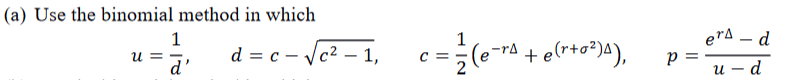

In [3]:
def u1(dt, opt_ctx):
    return 1/d1(dt, opt_ctx)
def d1(dt, opt_ctx):
    c = c1(dt, opt_ctx)
    return c - np.sqrt(c*c -1)
def c1(dt, opt_ctx):
    r = opt_ctx.r
    sigma = opt_ctx.sigma
    return 0.5 * ((1/np.exp(r*dt)) + (np.exp(r*dt+sigma*sigma*dt)))    
def p1(dt, opt_ctx):
    r = opt_ctx.r
    return (np.exp(r * dt) - d1(dt, opt_ctx))/(u1(dt, opt_ctx) - d1(dt, opt_ctx))

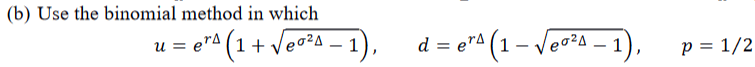

In [4]:
def u2(dt, opt_ctx):
    sigma = opt_ctx.sigma
    r = opt_ctx.r
    return (np.exp(r*dt)) * (1+np.sqrt(np.exp(sigma * sigma * dt) - 1))
def d2(dt, opt_ctx):
    sigma = opt_ctx.sigma
    r = opt_ctx.r
    return (np.exp(r*dt)) * (1-np.sqrt(np.exp(sigma * sigma * dt) - 1))
def p2(dt, opt_ctx):
    return 0.5

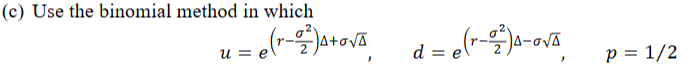

In [5]:
def u3(dt, opt_ctx):
    sigma = opt_ctx.sigma
    r = opt_ctx.r
    return np.exp((r - sigma*sigma/2)*dt + sigma*np.sqrt(dt))
def d3(dt, opt_ctx):
    sigma = opt_ctx.sigma
    r = opt_ctx.r
    return np.exp((r - sigma*sigma/2)*dt - sigma*np.sqrt(dt))
def p3(dt, opt_ctx):
    return 0.5

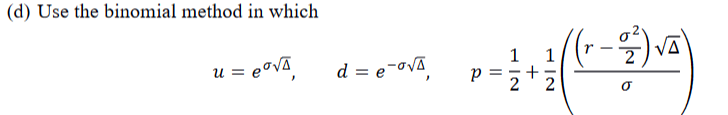

In [6]:
def u4(dt, opt_ctx):
    sigma = opt_ctx.sigma
    return np.exp(sigma * (dt ** 0.5))
def d4(dt, opt_ctx):
    return 1/u4(dt, opt_ctx)
def p4(dt, opt_ctx):
    sigma = opt_ctx.sigma
    r = opt_ctx.r
    return 0.5 + (0.5 * ((r - sigma*sigma/2)* (dt ** 0.5))  / sigma)

### $ S_0 = 32 $  &nbsp;&nbsp;&nbsp;&nbsp; K = 30   &nbsp;&nbsp;&nbsp;&nbsp; $ \sigma = 24\% $    &nbsp;&nbsp;&nbsp;&nbsp;   r = 5%    &nbsp;&nbsp;&nbsp;&nbsp; T = 6months = 0.5 years

In [7]:
T = 0.5 # 6 months
r = 0.05
sigma = 0.24
S0 = 32
K = 30
opt_ctx = OptionContext(K, r, sigma, T)

In [8]:
all_n = [10,20,40,80,100,200,500]

call_price_a = []
call_price_b = []
call_price_c = []
call_price_d = []

call_bs = []

for n in all_n:
    dt = T/n
    
    # (a)
    u = u1(dt, opt_ctx)
    d = d1(dt, opt_ctx)
    p = p1(dt, opt_ctx)
    call_price_a.append(binomial_model(p, u, d, S0, opt_ctx, n))
    
    # (b)
    u = u2(dt, opt_ctx)
    d = d2(dt, opt_ctx)
    p = p2(dt, opt_ctx)
    call_price_b.append(binomial_model(p, u, d, S0, opt_ctx, n))
    
    # (c)
    u = u3(dt, opt_ctx)
    d = d3(dt, opt_ctx)
    p = p3(dt, opt_ctx)
    call_price_c.append(binomial_model(p, u, d, S0, opt_ctx, n))
    
    # (d)
    u = u4(dt, opt_ctx)
    d = d4(dt, opt_ctx)
    p = p4(dt, opt_ctx)
    call_price_d.append(binomial_model(p, u, d, S0, opt_ctx, n))
    
    # Black scholes
    call_bs.append(black_scholes_call(S0, opt_ctx))

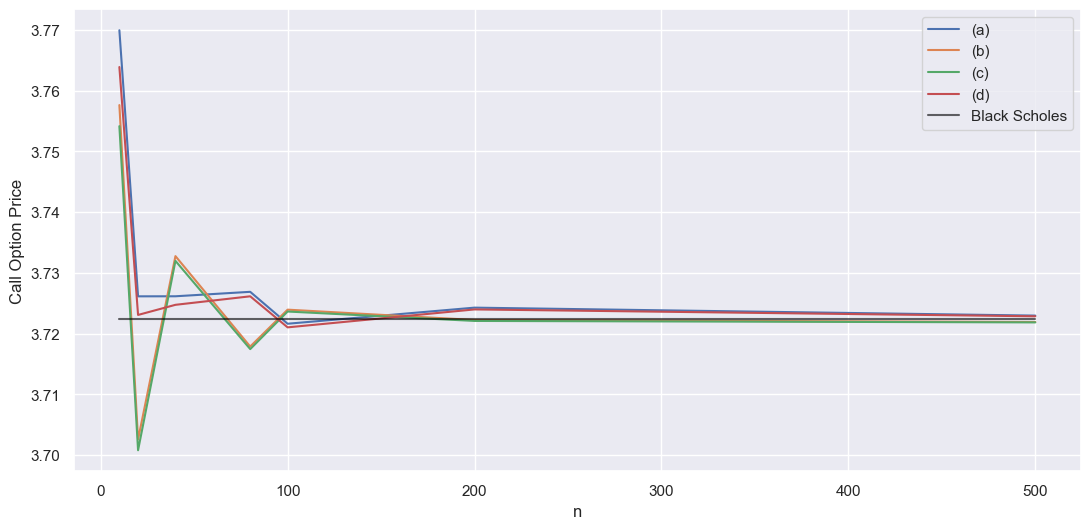

In [9]:
plt.figure(figsize=(13,6))
plt.xlabel("n")
plt.ylabel("Call Option Price")
plt.plot(all_n, call_price_a, label="(a)")
plt.plot(all_n, call_price_b, label="(b)")
plt.plot(all_n, call_price_c, label="(c)")
plt.plot(all_n, call_price_d, label="(d)")
plt.plot(all_n, call_bs, color="black", alpha=0.6, label="Black Scholes")
plt.legend()

# 2. Sensitivities of American options

In [10]:
# Prices the american option given up states, down states, probablity of up state and modeling parameters
def price_american_call(p, u, d, s0, op_ctx, n):
    
    dt = op_ctx.T/n
    
    pu = p
    pd = 1-p
    
    # Initialize the terminal row of the binomial tree with the option payoffs at maturity
    tree = [max(s0 * u ** i * d ** (n - i) - op_ctx.k, 0) for i in range(n + 1)]

    # Iterate backwards through the tree, calculating option values at each level
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            x = np.exp(-op_ctx.r * dt) * (pu * tree[j + 1] + pd * tree[j])
            c = max(s0 * u ** j * d ** (i - j) * np.exp(-op_ctx.y * dt) - op_ctx.k, 0)
            tree[j] = max(x, c)
    
    return tree[0]

# Calculate sensitivities using finite differencing
def price_greeks(p, u, d, s0, op_ctx, n, bump):
    
    dt = op_ctx.T/n
    
    pu = p
    pd = 1-p
    
    # Calculate option value at S0
    option_value = price_american_call(p,u,d,s0,op_ctx,n)

    # Calculate option value at S0 + ΔS and S0 - ΔS for Delta and Gamma estimation
    delta_s = bump*s0
    option_value_plus = price_american_call(p,u,d,s0 + delta_s,op_ctx,n)
    option_value_minus = price_american_call(p,u,d,s0 - delta_s,op_ctx,n)
    
    # Estimate Delta
    delta = (option_value_plus - option_value_minus) / (2 * delta_s)
    
    # Estimate Gamma
    gamma = (option_value_plus - 2 * option_value + option_value_minus) / (delta_s ** 2)
    
    #Estimate Vega
    op_ctx_high_vol = OptionContext(op_ctx.k, op_ctx.r, op_ctx.sigma + op_ctx.sigma*bump, op_ctx.T)
    option_value_high_vol = price_american_call(p, u, d, s0, op_ctx_high_vol, n)
    vega = (option_value_high_vol - option_value) / (op_ctx.sigma*bump)
    
    #Estimate Theta
    op_ctx_future = OptionContext(op_ctx.k, op_ctx.r, op_ctx.sigma, op_ctx.T + op_ctx.T*bump)
    option_value_future = price_american_call(p, u, d, s0, op_ctx_future, n)
    theta = (option_value_future - option_value) / (op_ctx.T*bump)
    
    return delta, vega, gamma, theta

### $ S_0 = 49 $  &nbsp;&nbsp;&nbsp;&nbsp; K = 50   &nbsp;&nbsp;&nbsp;&nbsp; $ \sigma = 28\% $    &nbsp;&nbsp;&nbsp;&nbsp;   r = 5%    &nbsp;&nbsp;&nbsp;&nbsp; T = 20 weeks = 0.3846 &nbsp;&nbsp;&nbsp;&nbsp;  $\mu = 0.14 $ 

### We will use parameter choice (d) from previous question

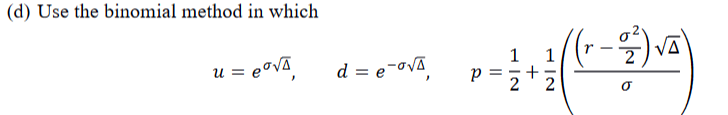

In [11]:
T = 0.3846 # 20 weeks
r = 0.05
sigma = 0.28
S0 = 49
K = 30
y = 0.14
opt_ctx = OptionContext(K, r, sigma, T, y)

u = u1(dt, opt_ctx)
d = d1(dt, opt_ctx)
p = p1(dt, opt_ctx)

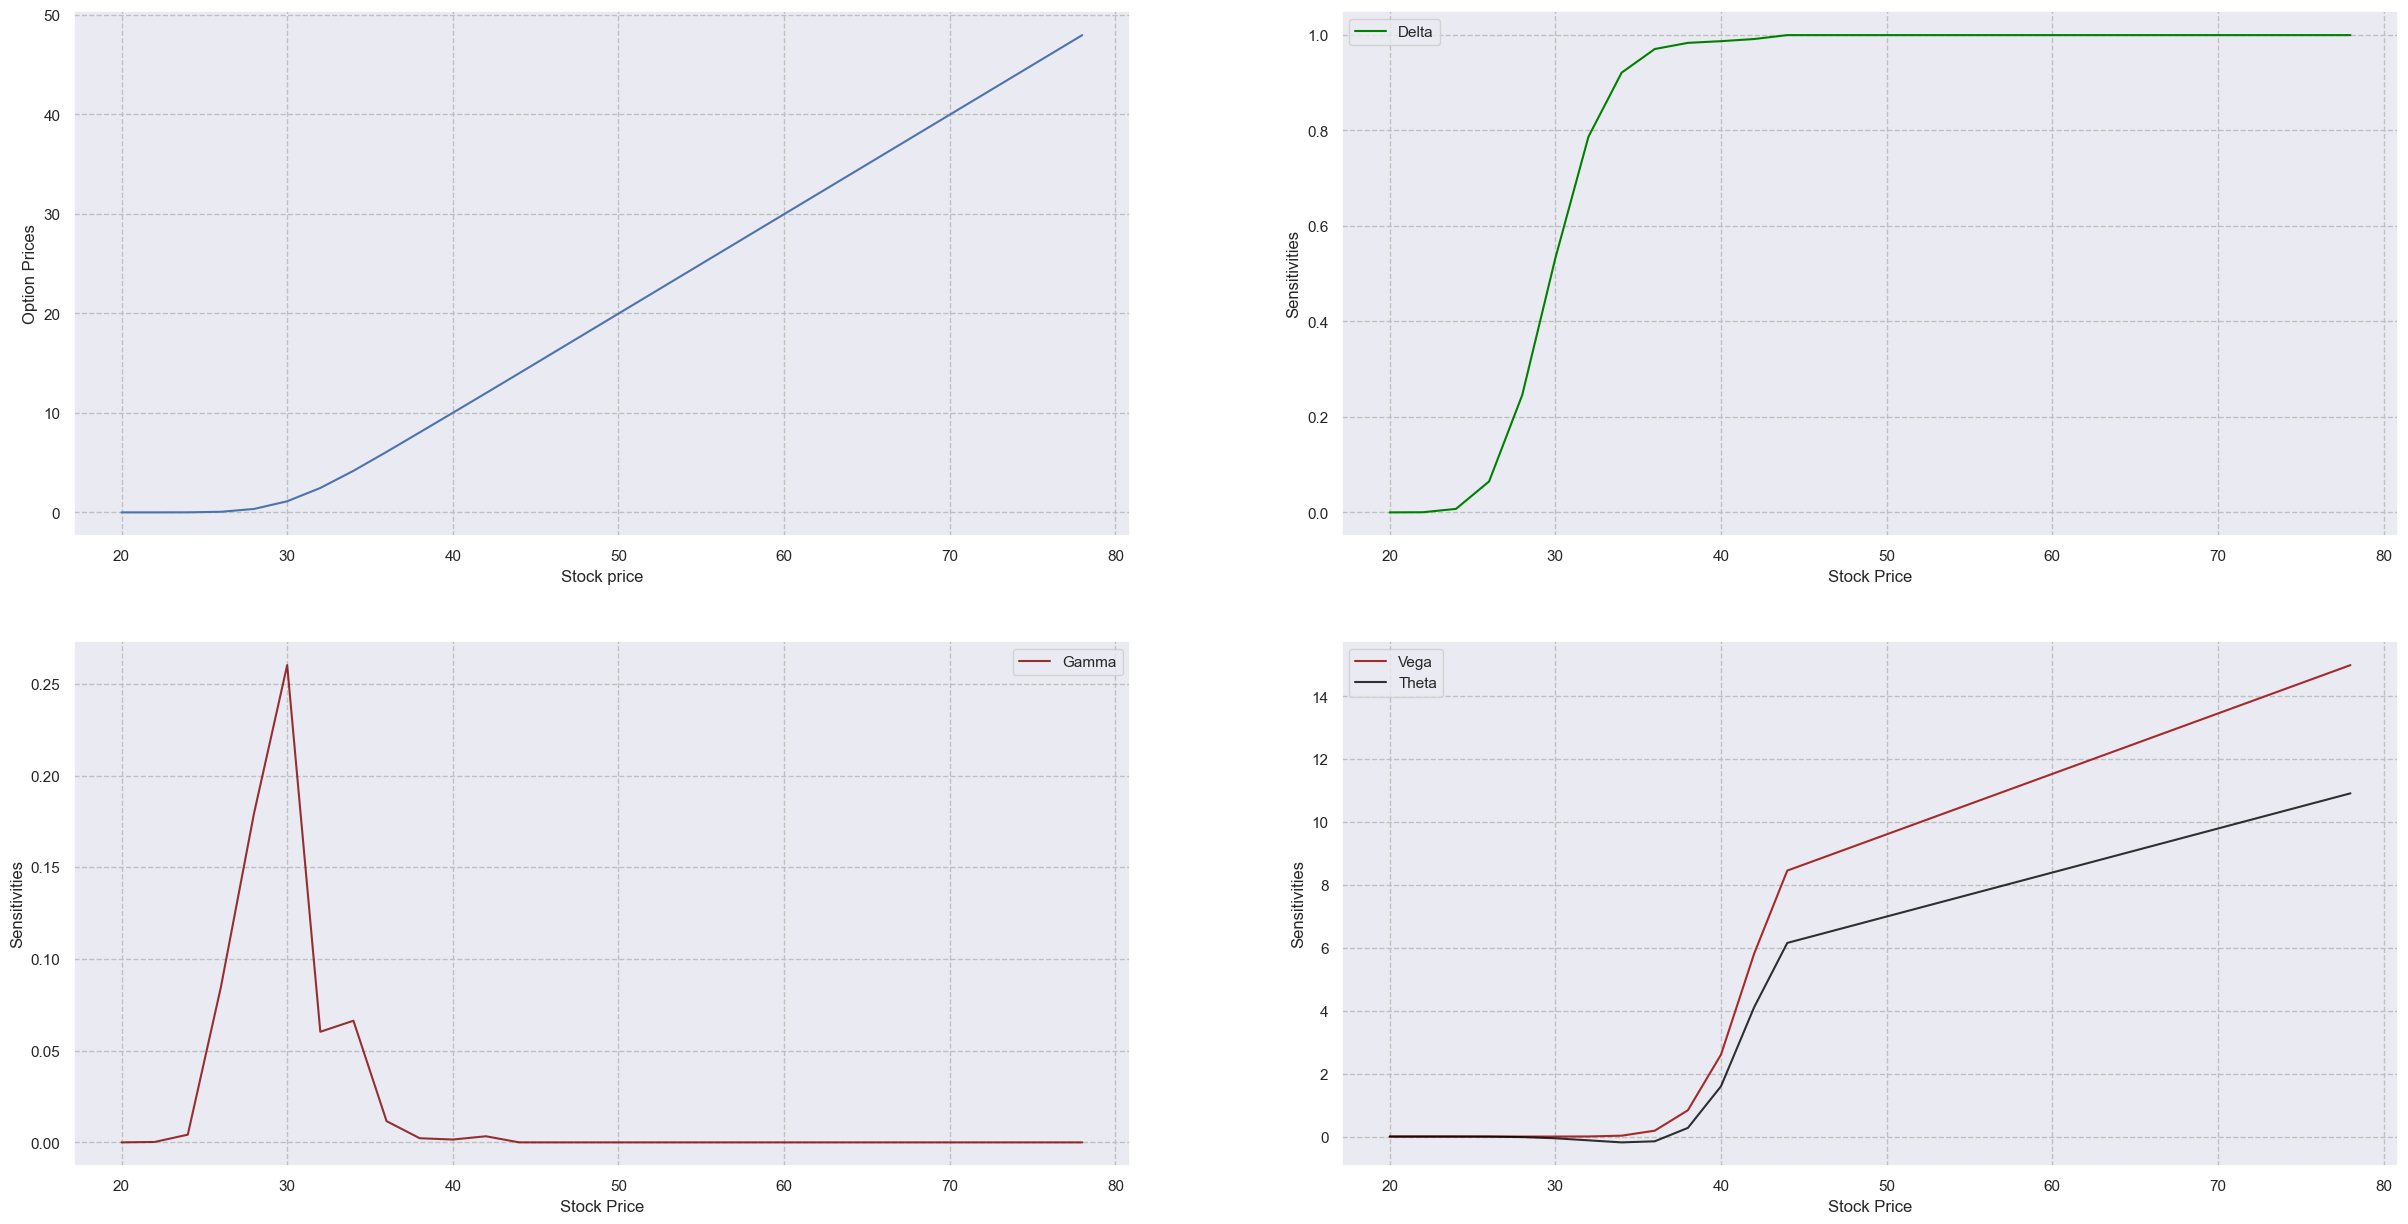

In [12]:
deltas = []
vegas = []
gammas = []
thetas = []
option_prices = []
S = []

for i in range(30):
    s = 20 + i*2
    delta, vega, gamma, theta = price_greeks(p, u, d, s, opt_ctx, 100, 0.01)
    deltas.append(delta)
    vegas.append(vega)
    gammas.append(gamma)
    thetas.append(theta)
    option_prices.append(price_american_call(p, u, d, s, opt_ctx, 100))
    S.append(s)
    
plt.figure(figsize=(30,15))
    
plt.subplot(2,2,1)
plt.grid(linestyle="--", color="silver")
plt.xlabel("Stock price")
plt.ylabel("Option Prices")
plt.plot(S, option_prices)

plt.subplot(2,2,2)
plt.grid(linestyle="--", color="silver")
plt.xlabel("Stock Price")
plt.ylabel("Sensitivities")
plt.plot(S, deltas, color="green", label="Delta")
plt.legend()

plt.subplot(2,2,3)
plt.grid(linestyle="--", color="silver")
plt.xlabel("Stock Price")
plt.ylabel("Sensitivities")
plt.plot(S, gammas, label="Gamma", color="maroon", alpha=0.8)
plt.legend()

plt.subplot(2,2,4)
plt.grid(linestyle="--", color="silver")
plt.xlabel("Stock Price")
plt.ylabel("Sensitivities")
plt.plot(S, vegas, color="brown", label="Vega")
plt.plot(S, thetas, color="black", label="Theta", alpha=0.8)
plt.legend()


# 3. Trinomial Model

In [13]:
# Prices the European option given up, middle, down states, probabilities, and modeling parameters. 
# There is an additional parameter to account for state conditions which are additive instead of multiplicative in nature
def trinomial_model(pu, pd, up, down, s0, op_ctx, n, log_process=False):
    
    dt = op_ctx.T/n
    pm = 1 - (pu+pd)
    
    # Initialize the trinomial tree with option payoffs as 0 for all the mid states
    tree = [[0] * (2 * i + 1) for i in range(n + 1)]

    # Terminal payoffs
    for i in range(2 * n + 1):
        if log_process:
            m = 0
            price = s0 + (up * max(n - i, 0)) + (m * i) + (down * (n - (n - i)))
        else:
            m = 1
            price = s0 * up ** max(n - i, 0) * m ** i * down ** (n - (n - i))
        tree[n][i] = max(price - op_ctx.k, 0)
    
    # Iterate backwards through the tree, calculating option values at each level
    for i in range(n - 1, -1, -1):
        for j in range(2 * i + 1):
            tree[i][j] = np.exp(-op_ctx.r * dt) * (pu * tree[i + 1][j] + pm * tree[i + 1][j + 1] + pd * tree[i + 1][j + 2])

    return tree[0][0]

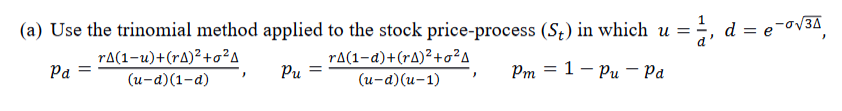

In [14]:
def q3_u1(dt, opt_ctx):
    return 1/q3_d1(dt, opt_ctx)
def q3_d1(dt, opt_ctx):
    sigma = opt_ctx.sigma
    return np.exp(-sigma*np.sqrt(3*dt))
def q3_pd1(dt, opt_ctx):
    r = opt_ctx.r
    sigma = opt_ctx.sigma
    u = q3_u1(dt, opt_ctx)
    d = q3_d1(dt, opt_ctx)
    numerator = r*dt*(1-u) + (r*dt)**2 + (sigma**2)*dt
    denom = (u-d)*(1-d)
    return numerator/denom
def q3_pu1(dt, opt_ctx):
    r = opt_ctx.r
    sigma = opt_ctx.sigma
    u = q3_u1(dt, opt_ctx)
    d = q3_d1(dt, opt_ctx)
    numerator = r*dt*(1-d) + (r*dt)**2 + (sigma**2)*dt
    denom = (u-d)*(u-1)
    return numerator/denom

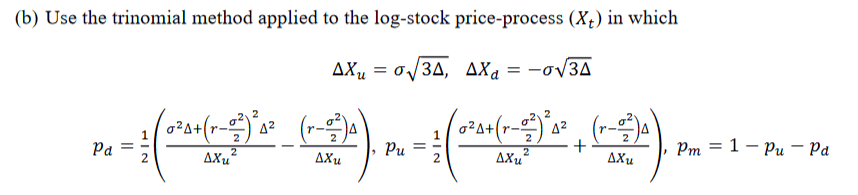

In [15]:
def q3_u2(dt, opt_ctx):
    return opt_ctx.sigma * np.sqrt(3*dt)
def q3_d2(dt, opt_ctx):
    return -opt_ctx.sigma * np.sqrt(3*dt)
def q3_pd2(dt, opt_ctx):
    r = opt_ctx.r
    sigma = opt_ctx.sigma
    dx_u = q3_u2(dt, opt_ctx)
    frac1 = ((sigma**2 * dt) + ((r - sigma**2 / 2)**2 * dt**2)) / dx_u**2
    frac2 = ((r - sigma**2 / 2)*dt) / dx_u
    return 0.5 * (frac1 - frac2)
def q3_pu2(dt, opt_ctx):
    r = opt_ctx.r
    sigma = opt_ctx.sigma
    dx_u = q3_u2(dt, opt_ctx)
    frac1 = ((sigma**2 * dt) + ((r - sigma**2 / 2)**2 * dt**2)) / dx_u**2
    frac2 = ((r - sigma**2 / 2)*dt) / dx_u
    return 0.5 * (frac1 + frac2)

### $ S_0 = 32 $  &nbsp;&nbsp;&nbsp;&nbsp; K = 30   &nbsp;&nbsp;&nbsp;&nbsp; $ \sigma = 24\% $    &nbsp;&nbsp;&nbsp;&nbsp;   r = 5%    &nbsp;&nbsp;&nbsp;&nbsp; T = 6 months = 0.5

In [16]:
T = 0.5 
r = 0.05
sigma = 0.24
S0 = 32
K = 30
opt_ctx = OptionContext(K, r, sigma, T)

In [17]:
all_n = [10,20,40,80,100,200,500]

call_price_a = []
call_price_b = []

for n in all_n:
    dt = T/n
    
    # (a)
    u = q3_u1(dt, opt_ctx)
    d = q3_d1(dt, opt_ctx)
    pu = q3_pu1(dt, opt_ctx)
    pd = q3_pd1(dt, opt_ctx)
    call_price_a.append(trinomial_model(pu, pd, u, d, S0, opt_ctx, n))
    
    # (b)
    u = q3_u2(dt, opt_ctx)
    d = q3_d2(dt, opt_ctx)
    pu = q3_pu2(dt, opt_ctx)
    pd = q3_pd2(dt, opt_ctx)
    call_price_b.append(trinomial_model(pu, pd, u, d, S0, opt_ctx, n, log_process=True))    

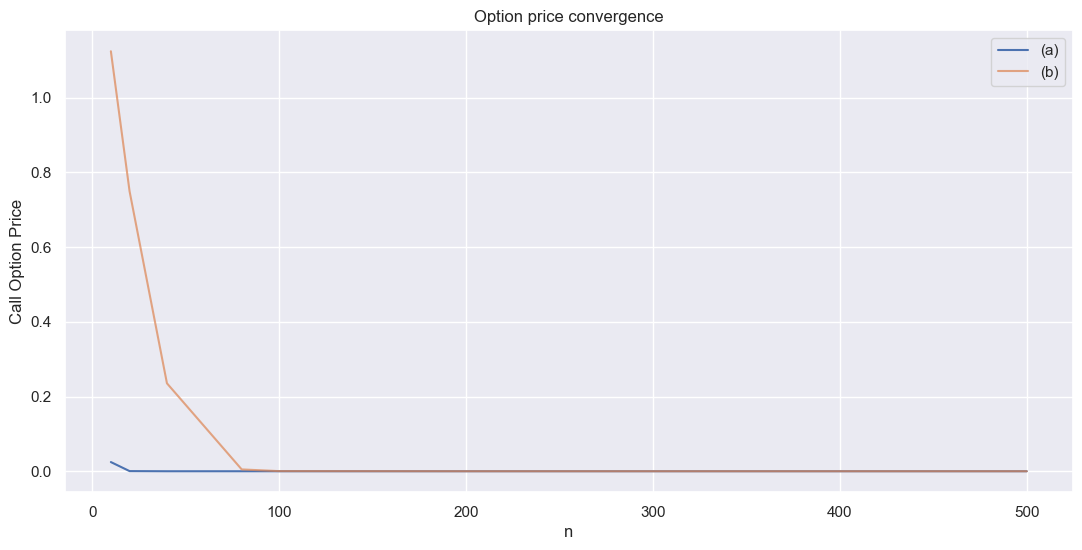

In [18]:
plt.figure(figsize=(13,6))
plt.title("Option price convergence")
plt.xlabel("n")
plt.ylabel("Call Option Price")
plt.plot(all_n, call_price_a, label="(a)")
plt.plot(all_n, call_price_b, label="(b)", alpha=0.7)
plt.legend()

# 4. Halton’s Low-Discrepancy Sequences Call Option Pricing model

In [19]:
def halton_sequence(N, bases):
    num_dims = len(bases)
    seq = np.zeros((N, num_dims))
    for i in range(N):
        for j in range(num_dims):
            b = bases[j]
            d = 0
            f = 1.0 / b
            n = i
            while n > 0:
                d += f * (n % b)
                n //= b
                f /= b
            seq[i, j] = d
    return seq

In [21]:
b1 = int(input("Enter Halton Base b1: "))
b2 = int(input("Enter Halton Base b2: "))
N = int(input("Enter Number of points N: "))

S0 = float(input("Enter initial stock price S0: "))
K = float(input("Enter option strike X: "))
T = float(input("Enter time to maturity T: "))
r = float(input("Enter interest rate r: "))
sigma = float(input("Enter volatility : "))

Enter Halton Base b1: 3
Enter Halton Base b2: 7
Enter Number of points N: 10000
Enter initial stock price S0: 32
Enter option strike X: 30
Enter time to maturity T: 0.5
Enter interest rate r: 0.05
Enter volatility : 0.24


In [22]:
halton = halton_sequence(N, [b1,b2])
e = np.e

# Box Muller transform
z1 = np.array([np.sqrt(-2*np.log(h1 + 1e-10)) * np.cos(2 * np.pi * h2) for h1, h2 in halton])
z2 = np.array([np.sqrt(-2*np.log(h1 + 1e-10)) * np.sin(2 * np.pi * h2) for h1, h2 in halton])

# Simulate S(T)
ST1 = S0 * e ** ((r - ((sigma ** 2)/2)) * T + sigma * ((T) ** 0.5) * z1)
ST2 = S0 * e ** ((r - ((sigma ** 2)/2)) * T + sigma * ((T) ** 0.5) * z2)

# Simulate Calls
C1 = [max(0, ST-K) * e ** (-r * T) for ST in ST1]
C2 = [max(0, ST-K) * e ** (-r * T) for ST in ST2]

# Calculate Call option Value
call_price = 0.5 * (np.mean(C1) + np.mean(C2))
print(f"Call Option price: {call_price}")

Call Option price: 3.726747296389288
